# Flux analysis, methionine tracing

In [103]:
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from scipy.stats import norm
import sys

In [2]:
#  path to simpleflux package 
sys.path.append('C:/code/python/simpleflux/src')
from simpleflux.model import FluxModel, FluxState
from simpleflux.modelstate import ModelState
from simpleflux.fitting import ModelFit

In [41]:
input_data_path = Path('00_input_data')
heavy_fractions_path = Path('02_heavy_fractions')
results_path = Path('03_flux_analysis_results')

In [4]:
# make matplotlib use TrueType fonts for PDF export
matplotlib.rcParams['pdf.fonttype'] = 42

In [42]:
np.set_printoptions(precision=3, suppress=True)

## Define model

### Stoichiometry

In [5]:
stoichiometry = defaultdict(int, {
    ('MET_IN', 'met'): 1,
    ('PROT_SYNTH', 'met'): -1, ('PROT_SYNTH', 'metp'): 1, 
    ('AHCY', 'sah'): -1, ('AHCY', 'hcys'): 1, 
    ('METS', 'hcys'): -1, ('METS', 'met'): 1, 
    ('MAT', 'met'): -1, ('MAT', 'sam'): 1, 
    ('SAM_METH', 'sam'): -1, ('SAM_METH', 'sah'): 1, 
    ('CYSTS', 'hcys'): -1, ('CYSTS', 'cyst'): 1,
    ('CYSTL', 'cyst'): -1, ('CYSTL', 'akb'): 1,
    ('HCYS_OUT', 'hcys'): -1,
    ('PROT_OUT', 'metp'): -1,
    ('AKB_OUT', 'akb'): -1,
})

reversible_reactions = [
    'MET_IN',
    'PROT_SYNTH',
    'AHCY',
    'CYSTL',
]

free_reactions = ['CYSTS', 'METS', 'PROT_OUT', 'SAM_METH']

flux_model = FluxModel(stoichiometry, reversible_reactions, free_reactions)

In [6]:
flux_model.get_stoichiometry_df()

,AHCY,AKB_OUT,CYSTL,CYSTS,HCYS_OUT,MAT,METS,MET_IN,PROT_OUT,PROT_SYNTH,SAM_METH
akb,0,-1,1,0,0,0,0,0,0,0,0
cyst,0,0,-1,1,0,0,0,0,0,0,0
hcys,1,0,0,-1,-1,0,-1,0,0,0,0
met,0,0,0,0,0,-1,1,1,0,-1,0
metp,0,0,0,0,0,0,0,0,-1,1,0
sah,-1,0,0,0,0,0,0,0,0,0,1
sam,0,0,0,0,0,1,0,0,0,0,-1


## U-13C-methionine tracing

### Pool sizes

Estimated intracellular concentrations in uM

NOTE: we might leave out akb here

In [7]:
pool_size_data = pd.read_csv(input_data_path / 'U13C-met_concentrations.csv', sep=';', index_col=[0, 1])
pool_size_data

mean  std_dev
cell_type metabolite                  
BJ-TERT   hcys           10.0    10.00
          met           739.0     6.74
          sam            72.3     6.79
          sah             2.5     0.07
          cyst           16.3     0.90
          metp        23500.0  2350.00
          akb          1000.0  1000.00
BJ-RAS    hcys           10.0    10.00
          met           573.8    59.92
          sam           148.9    20.57
          sah             2.3     0.06
          cyst           16.3     0.90
          metp        23500.0  2350.00
          akb          1000.0  1000.00

### Measured fluxes

Measured fluxes (pmol / h * uL cells = uM / h).

In [8]:
measured_fluxes = pd.read_csv(input_data_path / 'U13C-met_measured_fluxes.csv', sep=';', index_col=[0, 1])
measured_fluxes

mean  std_dev
cell_type flux                   
BJ-TERT   PROT_OUT   416     83.0
          HCYS_OUT    64      6.4
BJ-RAS    PROT_OUT   520    104.0
          HCYS_OUT    53      5.3

### Heavy fractions

In [9]:
heavy_fractions = pd.read_csv(heavy_fractions_path / '13C-met_heavy_fractions.csv', index_col=[0, 1, 2])
# use time in hours
heavy_fractions.index = heavy_fractions.index\
    .set_levels(heavy_fractions.index.levels[1].astype('float64') / 60, level=1)\
    .rename(['cell_type', 'time_hours', 'replicate_nr'])
heavy_fractions.head(5)

cyst       met       sam
cell_type time_hours replicate_nr                                  
BJ-RAS    0.083333   1            -4.730827e-07  0.947336  0.128583
                     2            -4.730827e-07  0.958151  0.154254
          0.250000   1            -4.730827e-07  0.972891  0.475179
                     2            -4.730827e-07  0.970010  0.479771
          0.500000   1            -4.730827e-07  0.970564  0.735455

In [10]:
heavy_fraction_mean = heavy_fractions.groupby(level=[0, 1]).mean()
heavy_fraction_mean

cyst       met       sam
cell_type time_hours                                  
BJ-RAS    0.083333   -4.730827e-07  0.952744  0.141419
          0.250000   -4.730827e-07  0.971451  0.477475
          0.500000   -4.730827e-07  0.972464  0.743137
          1.000000   -4.730827e-07  0.972576  0.878904
          5.000000    3.797082e-01  0.984947  0.958616
          24.000000   7.779678e-01  0.976280  0.973534
BJ-TERT   0.083333   -4.730827e-07  0.965920  0.146616
          0.250000   -4.730827e-07  0.971597  0.468725
          0.500000   -4.730827e-07  0.977344  0.780345
          1.000000    1.283193e-01  0.976847  0.938402
          5.000000    6.647575e-01  0.982441  0.978226
          24.000000   7.412110e-01  0.973523  0.974370

In [11]:
min_std_dev = 0.02
heavy_fraction_sd = np.maximum(heavy_fractions.groupby(level=[0, 1]).std(), min_std_dev)

### Initial flux state

In [12]:
init_flux_state = FluxState.from_dict(
    flux_model,
    free_fluxes={
        'CYSTS' : 7,
        'METS': 85,
        'SAM_METH': 110,
        'PROT_OUT': 34,
    },
    exchanges={
        'MET_IN' : 0.4,
        'PROT_SYNTH': 0.4,
        'AHCY': 0.4,
        'CYSTL': 0.4,
    }
)

In [13]:
initial_state = ModelState(
    model=flux_model,
    flux_state=init_flux_state,
    concentrations=pool_size_data.loc['BJ-TERT'].loc[flux_model.metabolites, 'mean'].to_numpy(),
    medium_mi={'MET_IN': 1.0}
)

### Fit model

In [14]:
cell_types = ['BJ-TERT', 'BJ-RAS']

In [15]:
model_fits = {
    cell_type: ModelFit(
        initial_state,
        measured_mi = heavy_fraction_mean.loc[cell_type],
        measured_mi_std_dev = heavy_fraction_sd.loc[cell_type],
        measured_fluxes=measured_fluxes.loc[cell_type],
        measured_conc=pool_size_data.loc[cell_type]
    )
    for cell_type in cell_types
}

Initial residuals

In [16]:
[model_fits[cell_type].model_residual() for cell_type in cell_types]

[array([-6.72386916e-05,  4.77479540e+01,  7.29734340e+00, -3.41873220e-03,
         4.69722922e+01,  2.31629866e+01, -3.76678356e-02,  4.57514683e+01,
         3.80658240e+01,  5.22329975e+00,  4.29459933e+01,  4.39698885e+01,
         1.06791884e+01,  2.75777280e+01,  2.94415487e+01,  1.20231070e+01,
         8.95560542e+00,  9.13026997e+00,  4.60240964e+00,  7.18750000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]),
 array([-6.72386916e-05,  4.70891321e+01,  7.03748826e+00, -3.41873220e-03,
         4.69649562e+01,  2.36005194e+01, -3.76678356e-02,  4.55074582e+01,
         3.62054232e+01, -3.03980469e-01,  4.27324367e+01,  4.09950007e+01,
         6.20095027e+00,  2.77030214e+01,  2.84610518e+01,  7.78161304e+00,
         9.09348057e+00,  9.08845539e+00,  4.67307692e+00,  6.60377358e+00,
         0.00000000e+00, -2.75700935e+00,  3.72386971e+00, -3.33333333e+00,
         0.00000000e+00,  0

Fit models

In [17]:
for cell_type in cell_types:
    model_fits[cell_type].fit()

In [43]:
flux_model.get_flux_table(model_fits['BJ-TERT'].model_state.flux_state)

,net_flux,fwd_flux,rev_flux
AHCY,218.014496,218.035837,0.021342
AKB_OUT,4.574320,4.574320,0.000000
CYSTL,4.574320,6.214623,1.640303
CYSTS,4.574320,4.574320,0.000000
HCYS_OUT,63.965749,63.965749,0.000000
MAT,218.014496,218.014496,0.000000
METS,149.474427,149.474427,0.000000
MET_IN,471.531074,31316.868631,30845.337557
PROT_OUT,402.991006,402.991006,0.000000
PROT_SYNTH,402.991006,963.912522,560.921516


### Residuals

In [72]:
[
    pd.DataFrame(
        model_fits[cell_type].isotope_residual(),
        columns=heavy_fraction_mean.loc[cell_type].columns,
        index=heavy_fraction_mean.loc[cell_type].index
    )
    for cell_type in cell_types
]

[                cyst       met       sam
 time_hours                              
 0.083333   -0.012300  0.719187 -0.874837
 0.250000   -0.406304 -0.382353 -0.942787
 0.500000   -2.078377 -0.188040  1.489579
 1.000000   -0.465134 -0.292829  0.327609
 5.000000    1.464982 -0.156169 -0.357351
 24.000000  -0.328938 -0.986345 -0.939479,
                 cyst       met       sam
 time_hours                              
 0.083333   -0.014884  0.439863 -0.965278
 0.250000   -0.203026  0.418881  0.461714
 0.500000   -0.774078  0.292093  0.885657
 1.000000   -2.350207  0.143233 -1.660513
 5.000000    2.470675  0.433849 -0.859815
 24.000000  -1.508020 -0.769884 -0.899168]

### Model fit statistics

In [19]:
from scipy.stats import chi2

In [20]:
n_param = len(model_fits['BJ-TERT'].minimizer_result.params)
n_data_points = len(model_fits['BJ-TERT'].model_residual())
[n_param, n_data_points]

[15, 27]

Degrees of freedom and $\chi^2$ critical value

In [21]:
model_fit_level = 0.05
degrees_freedom = model_fits['BJ-TERT'].minimizer_result.nfree
[degrees_freedom, chi2.isf(model_fit_level, degrees_freedom)]

[12, 21.02606981748307]

Sum of squared residuals and model rejection p-values

In [44]:
pd.DataFrame(
    [
        [
            model_fits[cell_type].minimizer_result.chisqr,
            1 - chi2.cdf(model_fits[cell_type].minimizer_result.chisqr, degrees_freedom)
        ]
        for cell_type in cell_types
    ],
    index=cell_types, columns=['chi_square', 'p_value']
)

,chi_square,p_value
BJ-TERT,14.535544,0.267823
BJ-RAS,22.211603,0.035216


### Plot fitted data

In [54]:
t_simulated = np.arange(0, 24, 0.05)

In [88]:
def prepend_index_level(df: pd.DataFrame, values, name: str) -> pd.DataFrame:
    return df.assign(**{name: values}).set_index(name, append=True).swaplevel()

In [94]:
x_simulated = pd.concat(
    [
        prepend_index_level(
            model_fits[cell_type].model_state.simulate_to_pandas(t_simulated),
            cell_type, name='cell_type'
        )
        for cell_type in cell_types
    ]
)

In [59]:
def plot_model_fit(flux_model: FluxModel, x_predicted: pd.DataFrame,
                   heavy_fractions: pd.DataFrame, use_log_scale: bool = False) -> None:
    x_axis_margin = 0.05
    fig, axs = plt.subplots(ncols=len(flux_model.metabolites), figsize=(15,3))
    for i, metabolite in enumerate(flux_model.metabolites):
        axs[i].plot(x_predicted[metabolite])
        if metabolite in heavy_fractions.columns:
            axs[i].plot(heavy_fractions[metabolite], '.')
        axs[i].set_ylim(-x_axis_margin, 1 + x_axis_margin)
        axs[i].set_title(metabolite)
        if use_log_scale:
            axs[i].set_xscale('log')
            axs[i].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        axs[i].set_xticks(heavy_fractions.index)

In [57]:
def plot_file_name(cell_type: str, log_scale: bool) -> str:
    plot_name = 'met_fitted_data'
    if log_scale:
        scale_suffix = 'logscale'
    else:
        scale_suffix = 'linscale'
    return "_".join([cell_type, plot_name, scale_suffix]) + '.pdf'

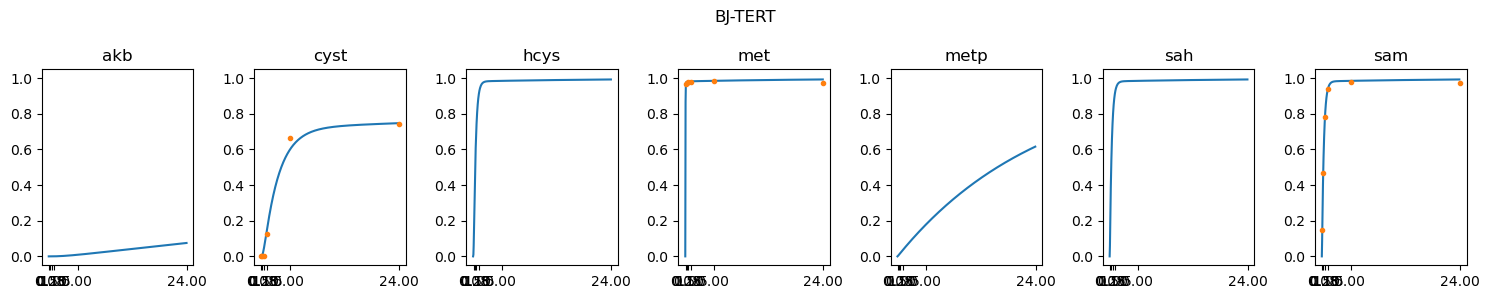

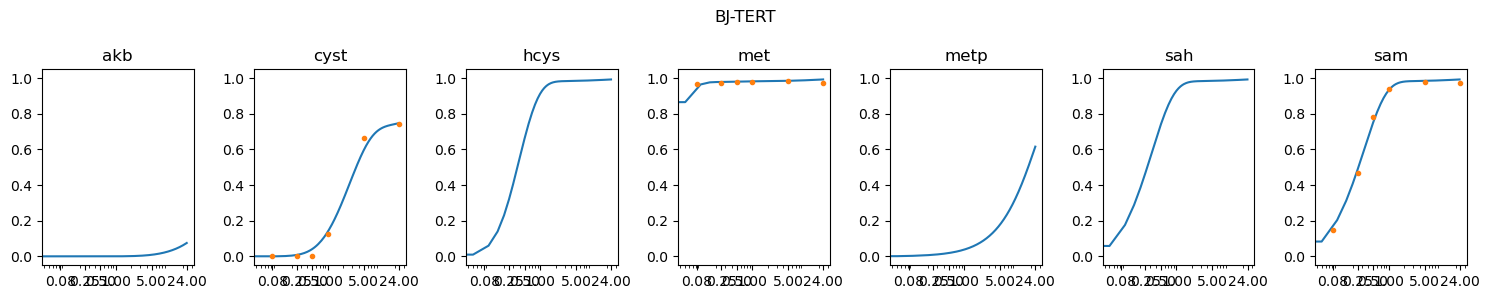

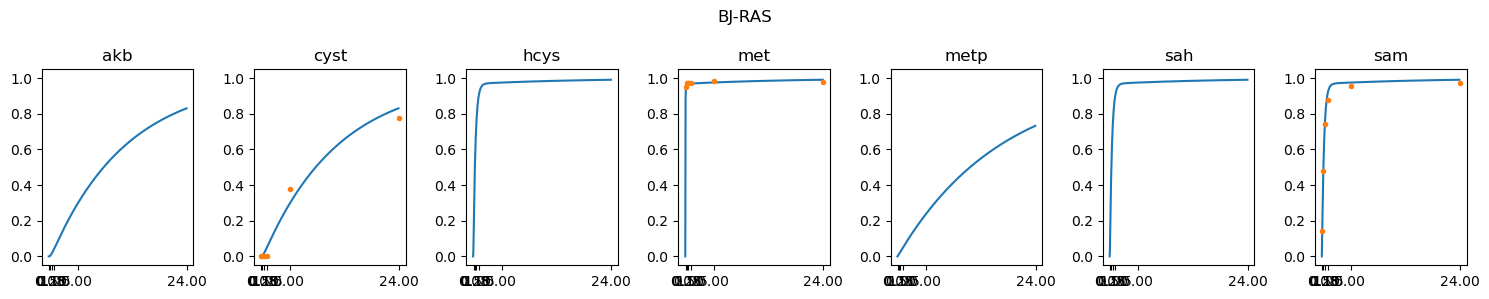

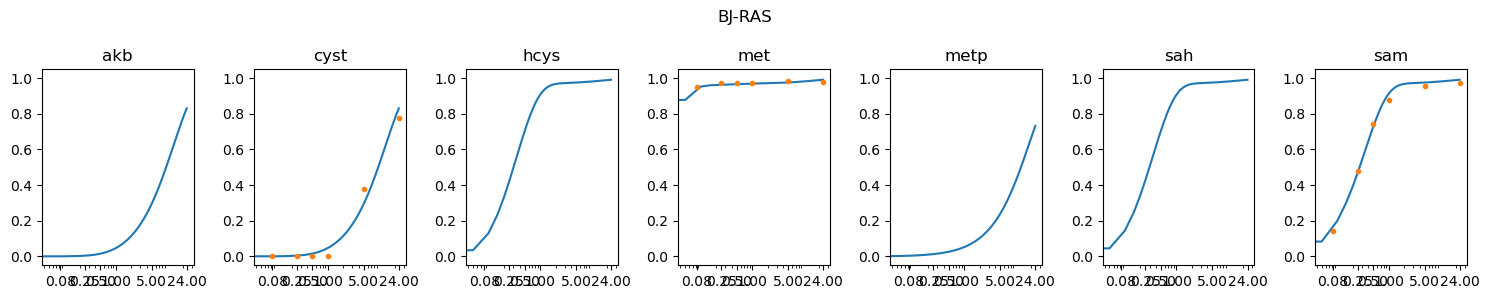

In [96]:
for cell_type in cell_types:
    for use_log_scale in [False, True]:
        plot_model_fit(
            flux_model, x_simulated.loc[cell_type], heavy_fraction_mean.loc[cell_type],
            use_log_scale=use_log_scale
        )
        plt.suptitle(cell_type)
        plt.tight_layout()
        plt.savefig(results_path / 'plots' / plot_file_name(cell_type, use_log_scale))

### Confidence intervals on estimated net fluxes
These are two-sided linearized confidence intervals, based on the parameter covariance from lmfit

In [101]:
def confidence_intervals_table(model_fit: ModelFit, ci_level: float) -> pd.DataFrame:
    fitted_net_fluxes = model_fit.model_state.flux_state.net_fluxes
    net_flux_std_err = model_fit.fitted_fluxes_std_err()
    ci_scale_factor = norm.isf((1 -ci_level)/2)
    return pd.DataFrame(
        {
            'net': fitted_net_fluxes,
            'std err': net_flux_std_err,
            'ci_half-width': net_flux_std_err*ci_scale_factor,
            'ci_lower': fitted_net_fluxes - net_flux_std_err*ci_scale_factor,
            'ci_upper': fitted_net_fluxes + net_flux_std_err*ci_scale_factor,
        },
        index=pd.Index(flux_model.reactions, name='reaction')
    )

In [104]:
ci_table = pd.concat(
    [
        prepend_index_level(
            confidence_intervals_table(model_fits[cell_type], ci_level=0.9).loc[free_reactions],
            cell_type, name='cell_type'
        )
        for cell_type in cell_types
    ]
)
ci_table

net     std err  ci_half-width    ci_lower  \
cell_type reaction                                                      
BJ-TERT   CYSTS       4.574320    0.948401       1.559982    3.014338   
          METS      149.474427   26.161293      43.031498  106.442930   
          PROT_OUT  402.991006   91.043820     149.753757  253.237249   
          SAM_METH  218.014496   25.101319      41.287996  176.726500   
BJ-RAS    CYSTS      81.822559  107.077428     176.126697  -94.304138   
          METS      295.359932  139.837333     230.011945   65.347987   
          PROT_OUT  481.470885  129.452971     212.931189  268.539695   
          SAM_METH  430.209081   87.217402     143.459861  286.749221   

                      ci_upper  
cell_type reaction              
BJ-TERT   CYSTS       6.134301  
          METS      192.505925  
          PROT_OUT  552.744763  
          SAM_METH  259.302491  
BJ-RAS    CYSTS     257.949256  
          METS      525.371876  
          PROT_OUT  694.402074  
          SAM_METH  573.668942

In [130]:
# since seaborn (strangely) does not support drawing error bars from specified values,
# we provide the (max, min) range as values and plot using median (midrange) and max/min for error bars
ci_table_for_seaborn = ci_table[['ci_lower', 'ci_upper']].melt(ignore_index=False).sort_index().reset_index()
ci_table_for_seaborn

,cell_type,reaction,variable,value
0,BJ-RAS,CYSTS,ci_lower,-94.304138
1,BJ-RAS,CYSTS,ci_upper,257.949256
2,BJ-RAS,METS,ci_lower,65.347987
3,BJ-RAS,METS,ci_upper,525.371876
4,BJ-RAS,PROT_OUT,ci_lower,268.539695
5,BJ-RAS,PROT_OUT,ci_upper,694.402074
6,BJ-RAS,SAM_METH,ci_lower,286.749221
7,BJ-RAS,SAM_METH,ci_upper,573.668942
8,BJ-TERT,CYSTS,ci_lower,3.014338
9,BJ-TERT,CYSTS,ci_upper,6.134301


<Axes: xlabel='reaction', ylabel='value'>

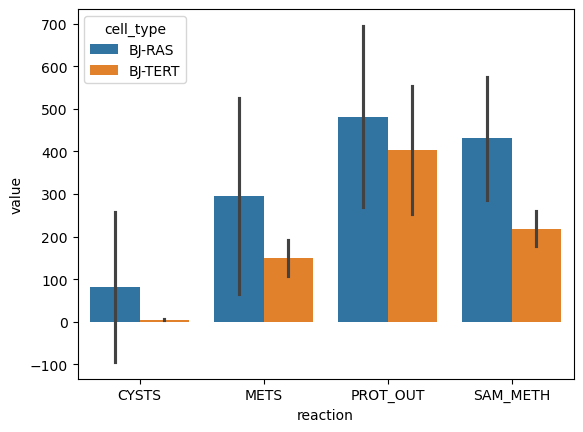

In [131]:
sns.barplot(
    ci_table_for_seaborn,
    x='reaction', y='value', hue='cell_type',
    estimator=np.median, errorbar=lambda x: [x.min(), x.max()]
)